# Data 620: Homework  Week 8
### Aaron Grzasko
### 10/21/2018

## Assignment Instructions

1. Choose a corpus of interest.
2. How many total unique words are in the corpus? (Please feel free to define unique words in any interesting,
defensible way).
3. Taking the most common words, how many unique words represent half of the total words in the corpus?
4. Identify the 200 highest frequency words in this corpus.
5. Create a graph that shows the relative frequency of these 200 words.
6. Does the observed relative frequency of these words follow Zipf’s law? Explain.
7. In what ways do you think the frequency of the words in this corpus differ from “all words in all corpora.”

## 1. Corpus

In this assignment, I analyze tweets from President Trump's Twitter account.  I use the *python-twitter* library to access tweet data via the Twitter API. 

To use the Twitter API, I first needed to create a Twitter developer account--see https://developer.twitter.com/.  Here are the setup steps:
* Go to the URL above.
* Click on the Apply button. Then click "Apply for developer account".
* Log in with your personal Twitter account credentials.
* Go to Apps -> "Create an app". 
* Fill out the form as required.

When finished with the setup, I was provided with the API keys and tokens required to work with the API.


Let's begin by downloading relevant libraries:

In [1]:
# import relevant python libraries
import twitter  # python-twitter library, this was pip-installed
import time
import json
import nltk
import nltk.corpus
import numpy as np
import matplotlib.pyplot as plt

#from nltk.corpus import stopwords
import re
from nltk.text import Text 
nltk.download() # download nltk collections from nltk book

%matplotlib inline

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


I stored my API credentials in file located in the working directory.   In the script below, I load the credentials into python.

In [2]:
# read in twitter API credential file 
"""
Credential file is in this format:
    {
        "consumer_key":"your_ck"
        "consumer_secret":"your_cs
        "access_token_key":"your_atk",
        "access_token_secret":"your_ats
    }
"""

f = open('.cred.json', 'r')
creds = json.load(f)
f.close()


Below, I verify that the credentials are valid.

In [3]:
# Connect to the twitter api
twitter_api = twitter.Api(consumer_key=creds["consumer_key"],
                          consumer_secret=creds["consumer_secret"],
                          access_token_key=creds["access_token_key"],
                          access_token_secret=creds["access_token_secret"],
                          tweet_mode='extended')
# verify credentials
twitter_api.VerifyCredentials()


User(ID=858508304661839875, ScreenName=agrzasko)

I am now connected to the Twitter API.

Twitter limits the number of tweets pulled within short periods of time; so I will be unable to pull the entire Trump canon (34k+ tweets) in one fell swoop.

Below, I pull as many Trump tweets as the API will allow within a 15 minute interval.  

*Note:  Twitter limits the number of tweet retrievals with each query to 200; so I perform multiple API queries in a loop*. 


In [ ]:
# get latest trump tweets in max size, append tweet text to list
tweet_list = []
tweets = twitter_api.GetUserTimeline(screen_name="realDonaldTrump", count=200)
for s in tweets:
    tweet_list.append(s.full_text)

# get as many additional, historical tweets as the api will allow,
# given rate limit constraints
for i in range(200):
    try:
        # pull tweets with id <= last id from previous pull
        tweets = twitter_api.GetUserTimeline(screen_name="realDonaldTrump", \
                                             count=200, \
                                             max_id = tweets[len(tweets)-1].id)
        # first tweet in new pull is a duplicate; delete
        tweets.pop(0) 
        
        # append each new tweet to tweet_list
        for s in tweets:
            tweet_list.append(s.full_text)
        time.sleep(0.2)
    except:
        print("Reached the end, or there was an error!")
        break
   


Let's save the tweet data to a text file in the working directory.  

In [ ]:
# write tweet to txt file
with open('trump_tweets.txt', 'w', encoding="utf-8") as f:
    for item in tweet_list:
        f.write("%s\n" % item) 

Now I will read in the tweet file:

In [8]:
# read in trump tweet text file       
with open("trump_tweets.txt", "r", encoding = "utf-8") as f:
    trump = f.readlines()

Here are the number of tweets retrieved:

In [9]:
# tweet count 
len(trump)

3453

Let's look at the first handful of tweets:

In [10]:
# read in first 5 tweets
trump[0:5]

['Best Jobs Numbers in the history of our great Country! Many other things likewise. So why wouldn’t we win the Midterms? Dems can never do even nearly as well! Think of what will happen to your now beautiful 401-k’s!\n',
 'The Caravans are a disgrace to the Democrat Party. Change the immigration laws NOW!\n',
 'Full efforts are being made to stop the onslaught of illegal aliens from crossing our Souther Border. People have to apply for asylum in Mexico first, and if they fail to do that, the U.S. will turn them away. The courts are asking the U.S. to do things that are not doable!\n',
 'Watched North Dakota’s Rep. Kevin Cramer easily win debate with Senator Heidi Heitkamp. Great job Kevin, you will be a great Senator!\n',
 'All levels of government and Law Enforcement are watching carefully for VOTER FRAUD, including during EARLY VOTING. Cheat at your own peril. Violators will be subject to maximum penalties, both civil and criminal!\n']

I need to do some light cleanup of the tweet data before I can do meaningful analysis:


In [11]:
# convert tweets from list to string.
trump = " ".join(trump)

# remove URL references
trump = re.sub('https://[\\w\\./]+','', trump) 

# remove hashtag references
trump = re.sub('#\\w+','',trump) 

# remove retweet abbreviation 
trump = trump.replace("RT @"," @")

# remove reference to other users' twitter handles
trump = re.sub('@[\\w:]+','',trump) 

# change "&" to "and"
trump = trump.replace("&amp","and")


Using the *word_tokenize()*, I can convert the tweet text to a list of strings.

In [12]:
# separate out words in list
trump_words = nltk.word_tokenize(trump)

Finally, I will convert all words to lower case, and retain words that only contain alphabetical characters. 

In [13]:
# convert words to lower case; keep only words with all alphabetical chars
trump_words=[w.lower() for w in trump_words if w.isalpha()]

## 2. Unique Words

Below is a count of the number of unique words used in Trump's last 3,453 tweets.

In [14]:
# number of unique words
print("Number of unique words {}".format(len(set(trump_words))))

Number of unique words 6793


Let's see how the unique word count compares to the total word count:

In [15]:
# number of total words
print("Number of total words {}".format(len(trump_words)))

Number of total words 91500


I can now calculate lexical diversity, which is simply the ratio of unique word count to total word count:

In [16]:
# lexical diversity
print("Lexical Diversity: {0:.4f}".format(len(set(trump_words)) \
                                          / len(trump_words)))

Lexical Diversity: 0.0742


Let's now calculate the three measures above, but remove the most common Enlish words such as "the", "and", and "a":

In [17]:
# remove stop words from word list
trump_words_nostop = [w for w in trump_words if \
                      w not in nltk.corpus.stopwords.words('english')]

# number of unique words
print("Number of unique words, no stop words: {}".format(len(set(trump_words_nostop))))

# number of total words
print("Number of total words, no stop words: {}".format(len(trump_words_nostop)))
      
# lexical diversity
print("Lexical Diversity, no stop_words: {0:.4f}".format(len(set(trump_words_nostop)) \
                                          / len(trump_words_nostop)))

Number of unique words, no stop words: 6648
Number of total words, no stop words: 49165
Lexical Diversity, no stop_words: 0.1352


## 3. Words Representing Half of Corpus

In this section, I will determine the minimum number of unique words necessary to represent 50% of the total words used in Trump's tweets.  

To do this, I will use a custom function.  The function does the following:
* sorts the word_counts for each word in descending order.
* determines the 50th percentile location, given the total word count of the corpus
* returns the appropriate word number representing the median, given a word list sorted in descending order by count. 

In [18]:
# custom function to calculate median
def median_word_ct(words):
        
    # sort (words,count) in descending order
    sorted_freq = sorted([(k,v) for k,v in dict(nltk.FreqDist(words)).items()],\
              key=lambda x: x[1], reverse=True)
    # counts only
    counts = list(zip(*sorted_freq))[1]
    
    # find median location in word list
    median_loc = (len(words) + 1)*0.5
    
    # loop through count figures, calc cumulative totals
    total = 0
    index = -1 # start at -1 because we want our first incremented value to be 0
    for ct in counts:
        index += 1
        total += ct
        if total >= median_loc:
            return(index) # return index location location of median


 Here is the number of words necessary to represent 50% of the corpus:

In [19]:
# find number of words that represent 50% of corpus        
median_word_ct(trump_words) 

96

Let's calculate the required word count again, but exclude all stop words from the corpus:

In [20]:
# find number of non stop words that represent 50% of corpus        
median_word_ct(trump_words_nostop) 

334

## 4. Top 200 Words

Below are the top 200 most common words from the entire Trump tweet corpus:

In [21]:
# frequency dist
fdist = nltk.FreqDist(trump_words)

# Topp 200 words, all corpus
fdist.most_common(200)

[('the', 4640),
 ('and', 3144),
 ('to', 2545),
 ('of', 2011),
 ('a', 1641),
 ('is', 1418),
 ('in', 1401),
 ('for', 1092),
 ('on', 933),
 ('our', 894),
 ('are', 865),
 ('that', 799),
 ('i', 778),
 ('great', 771),
 ('will', 760),
 ('with', 760),
 ('we', 754),
 ('be', 717),
 ('it', 674),
 ('they', 573),
 ('have', 538),
 ('you', 524),
 ('was', 503),
 ('at', 481),
 ('this', 452),
 ('he', 414),
 ('has', 410),
 ('not', 409),
 ('people', 373),
 ('all', 372),
 ('t', 370),
 ('s', 354),
 ('by', 346),
 ('my', 342),
 ('very', 328),
 ('so', 319),
 ('as', 315),
 ('who', 306),
 ('president', 303),
 ('trump', 301),
 ('from', 283),
 ('no', 282),
 ('just', 280),
 ('country', 273),
 ('now', 266),
 ('their', 262),
 ('news', 252),
 ('more', 250),
 ('big', 248),
 ('his', 245),
 ('but', 241),
 ('there', 239),
 ('many', 238),
 ('thank', 237),
 ('democrats', 237),
 ('fake', 222),
 ('been', 213),
 ('america', 205),
 ('out', 203),
 ('today', 203),
 ('or', 203),
 ('about', 201),
 ('an', 201),
 ('than', 197),
 ('wo

As expected, the top of the list comprises very common English words (e.g. "the", "and", and "to").  

I can create a more interesting list by excluding the stopwords:

In [22]:
# frequency dist, no stop words
fdist_nostop = nltk.FreqDist(trump_words_nostop)

# Top 200 words, no stop words
fdist_nostop.most_common(200)

[('great', 771),
 ('people', 373),
 ('president', 303),
 ('trump', 301),
 ('country', 273),
 ('news', 252),
 ('big', 248),
 ('many', 238),
 ('thank', 237),
 ('democrats', 237),
 ('fake', 222),
 ('america', 205),
 ('today', 203),
 ('would', 194),
 ('much', 185),
 ('get', 181),
 ('time', 181),
 ('trade', 178),
 ('good', 177),
 ('new', 171),
 ('must', 170),
 ('want', 166),
 ('border', 163),
 ('tax', 159),
 ('make', 156),
 ('american', 151),
 ('never', 148),
 ('crime', 147),
 ('fbi', 147),
 ('years', 145),
 ('military', 142),
 ('back', 140),
 ('house', 130),
 ('going', 129),
 ('jobs', 128),
 ('one', 127),
 ('united', 126),
 ('state', 124),
 ('media', 124),
 ('ever', 123),
 ('even', 122),
 ('vote', 122),
 ('states', 122),
 ('russia', 122),
 ('north', 120),
 ('first', 117),
 ('job', 117),
 ('election', 117),
 ('korea', 117),
 ('collusion', 116),
 ('day', 115),
 ('bad', 114),
 ('done', 113),
 ('win', 110),
 ('honor', 110),
 ('witch', 110),
 ('strong', 109),
 ('hunt', 109),
 ('obama', 108),
 (

# 5. Graphs

Here is a cumulative, relative frequency plot for the top 200 words:

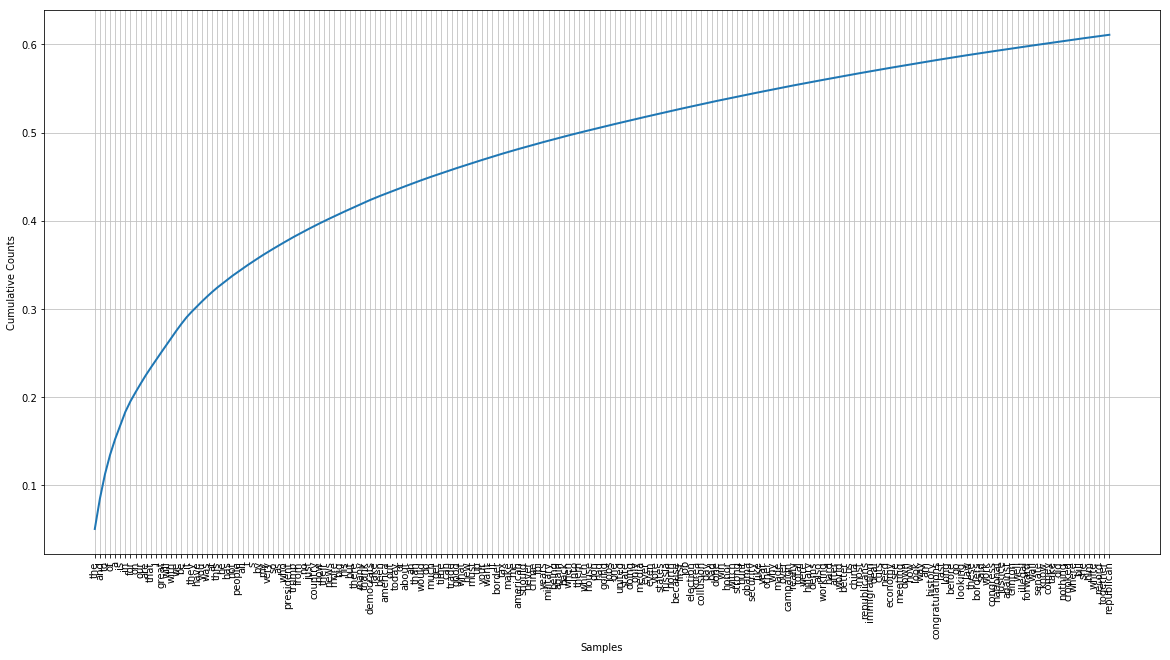

In [23]:
# convert frequency distribution to dictionary
fdist_relative = dict(fdist)

# calculate relative frequencies instead of raw counts
for k,v in fdist_relative.items():
    fdist_relative[k] = v / len(trump_words)

# convert back to FreqDist object
fdist_relative = nltk.FreqDist(fdist_relative)

# plot
plt.figure(figsize=(20,10))
fdist_relative.plot(200, cumulative=True)
plt.show()

The top 200 words in this plot comprise more than 60% of total words. 

Below is the cumulative, relative frequency plot, but removing all stop words from the corpus:

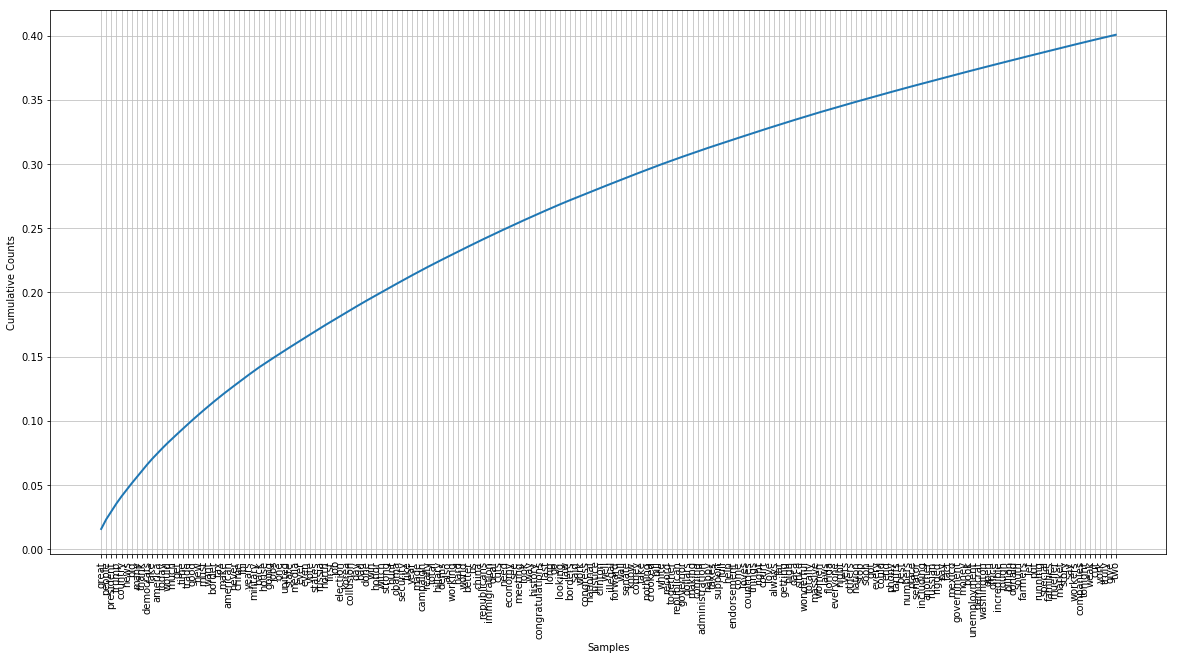

In [24]:
# convert frequency distribution to dictionary
fdist_relative_nostop = dict(fdist_nostop)

# calculate relative frequencies instead of raw counts
for k,v in fdist_relative_nostop.items():
    fdist_relative_nostop[k] = v / len(trump_words_nostop)

# convert back to FreqDist object
fdist_relative_nostop = nltk.FreqDist(fdist_relative_nostop)

# plot
plt.figure(figsize=(20,10))
fdist_relative_nostop.plot(200, cumulative=True)
plt.show()

In this plot, the top 200 non-stop words comprise only about 40% of all non-stop words. 

## 6. Zipf's Law

According to the Wikipedia entry on Zipf's law, the "frequency of any word is inversely proportional to its rank in the frequency table."

If this law holds, then each word will be inversely proportional to it's rank in the frequency table.  Thus, the top ranked word should appear roughly twice as often as the second ranked word, and three times as often as the third ranked word, etc.

Let's look at the frequency ratios for each of the top 3 words and the ten subsequent word frequencies:

In [25]:
# sorted frequency of words, word counts
sorted_freq = sorted([(k,v) for k,v in dict(nltk.FreqDist(trump_words)).items()],\
              key=lambda x: x[1], reverse=True)
# counts only
counts = list(zip(*sorted_freq))[1]

# top ranked word ratios
word1_ratios =  [counts[0] / x for x in counts[1:len(counts)]]

print("ratio of word 1 vs. subsequent words:")
[round(n, 2) for n in word1_ratios][0:10]


ratio of word 1 vs. subsequent words:


[1.48, 1.82, 2.31, 2.83, 3.27, 3.31, 4.25, 4.97, 5.19, 5.36]

In [26]:
# 2nd ranked word ratios
word2_ratios =  [counts[1] / x for x in counts[2:len(counts)]]

print("ratio of word 2 vs. subsquent words:")
[round(n, 2) for n in word2_ratios][0:10]


ratio of word 2 vs. subsquent words:


[1.24, 1.56, 1.92, 2.22, 2.24, 2.88, 3.37, 3.52, 3.63, 3.93]

In [27]:
# 3rd ranked word ratios
word3_ratios =  [counts[2] / x for x in counts[3:len(counts)]]

print("ratio of word 3 vs. subsquent words:")
[round(n, 2) for n in word3_ratios][0:10]


ratio of word 3 vs. subsquent words:


[1.27, 1.55, 1.79, 1.82, 2.33, 2.73, 2.85, 2.94, 3.19, 3.27]

The ratios above are significantly lower than what Zip's law would predict.  In other words, the frequency of lower ranked words do not drop off as quickly as expected under the law.

If Zipf's law holds, we would also exepct a log-log  line plot of word frequency to word rank to be approximately linear.  Below is a line plot (blue) with a corresponding best-fit line (orange).

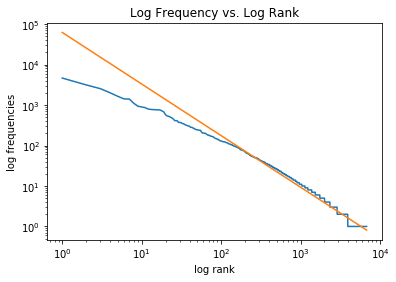

In [28]:
# two separate tuples of word rank (x) and word count (y)
x_y =  list(enumerate(counts,1))
x_y = list(zip(*x_y))

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(x_y[0], x_y[1])
plt.ylabel('log frequencies')
plt.xlabel('log rank')
plt.title('Log Frequency vs. Log Rank')

# best fit line
x = [np.log(n) for n in x_y[0]]
y = [np.log(n) for n in x_y[1]]
fit = np.polyfit(x, y,1)
fit_y = [np.exp(fit[0]*n + fit[1]) for n in x]
ax.plot(x_y[0],fit_y)

plt.show()


Once again, Zipf's law does not appear to hold for the Trump tweet corpus.  The lower frequency words do not drop off as quickly as anticpated under the law.  

## Trump Corpus vs. All Corpora

The writing on Twitter tends to be significantly different than the styles in other written media, such as as books, articles, or blogs.  Tweets are constrained to a very small number of characters; so the writing is forced to be brief and to-the-point. Abbreviations are common.  Spelling errors are also more likely on Twitter compared to other--more heavily edited--media.      

Therefore, I would not expect the Trump Twitter corpus to be very similar to broad-based corpora.

The messages on Trump's twitter feed are mostly political in nature; so the word frequencies could be similar to corpora with a focus on political rhetoric.

## Video Commentary

http://youtu.be/Au_Jcv8AliE?hd=1

## References

* Trump and Twitter API: https://medium.freecodecamp.org/learn-python-by-analyzing-donald-trumps-tweets-ccdf156cb5a3
* Twitter developer setup: https://developer.twitter.com/
* Zipf's law: https://en.wikipedia.org/wiki/Zipf%27s_law
* log-log scales in matplotlib: https://stackoverflow.com/questions/43837179/best-fit-line-on-log-log-scales-in-python-2-7
* “Natural Language Processing with Python.” NLTK Book, www.nltk.org/book/.

